### HVS Orbit Integration in a Dynamic MW+LMC Potential
This notebook performs a backward orbit integration for a single Hypervelocity Star (HVS) using a time-varying gravitational potential that accounts for the motion of both the Milky Way (MW) and the Large Magellanic Cloud (LMC). The primary goal is to compare the trajectory calculated in this more realistic, dynamic potential against the trajectory calculated in a simpler, static potential.

* **Data Loading:**
    * Loads the pre-processed 6D Cartesian phase-space data for the HVS sample.
    * Loads the center-of-mass orbital trajectories for both the MW and LMC, as derived from the Garavito-Camargo et al. (2019) simulations.

* **Potential & Integration:**
    * Imports the custom `MWPotential` class, which has been configured to use the MW and LMC orbital data to create a time-dependent potential.
    * Integrates the orbit of the HVS backward in time for 400 Myr using leapfrog integrator that handles the time-varying acceleration.

* **Comparison & Visualization:**
    * For comparison, it also integrates the same HVS orbit using Gala's built-in static `MilkyWayPotential`.
    * Generates a series of plots to visually compare the results from the two models:
        1.  A 3D plot of the orbital trajectories.
        2.  A set of 2D projections of the orbits (XY, XZ, YZ planes).
        3.  A plot of the total energy over time to check for conservation and compare the behavior of the two potentials.

#### Data loading

In [7]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
from tqdm import tqdm

# astropy and gala imports
from astropy import constants as const
import astropy.units as u
import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi

# package imports
script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, os.pardir))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from hvs_orbital_kinematics.potentials import MWPotential
from hvs_orbital_kinematics.integrators import leapfrog_step, leapfrog_step_time_varying

# define physical constants
G_KPC_MYR = const.G.to(u.kpc**3 / (u.Msun * u.Myr**2)).value
KM_S_TO_KPC_MYR = (u.km / u.s).to(u.kpc / u.Myr)

In [2]:
# load hvs data
hvs_data_path = os.path.join(project_root, 'data', 'processed', '6d_cartesian_data.csv')
cartesian_df = pd.read_csv(hvs_data_path)
print(f"Successfully loaded HVS data from {hvs_data_path}")

# load mw and lmc trajectory dataframes
mw_orbit_path = os.path.join(project_root, 'data', 'raw', 'trajectories', 'interp_mw_orbit.txt')
lmc_orbit_path = os.path.join(project_root, 'data', 'raw', 'trajectories', 'interp_lmc_orbit.txt')

print("Successfully loaded and processed MW and LMC orbital data.")

Successfully loaded HVS data from /mnt/c/Users/Andrew Qin/Desktop/HVS/data/processed/6d_cartesian_data.csv
Successfully loaded and processed MW and LMC orbital data.


# Comparison against Gala

#### Integration Settings

In [24]:
HVS_ID = 4 

N_STEPS = 800     
DT = -0.5        
times = np.arange(0, N_STEPS * DT, DT)

star_data = cartesian_df[cartesian_df['HVS'] == HVS_ID].iloc[0]
initial_pos = star_data[['x', 'y', 'z']].values.astype(float) # Position in kpc
initial_vel = star_data[['u', 'v', 'w']].values.astype(float) # Velocity in km/s
print(f"Integrating orbit for HVS {HVS_ID}")

initial_pos_custom = initial_pos
initial_vel_custom = initial_vel * KM_S_TO_KPC_MYR

initial_pos_gala = initial_pos * u.kpc
initial_vel_gala = initial_vel * u.km / u.s

Integrating orbit for HVS 4


#### First compare the static MW only vs Gala

Starting custom integration with static MW-only potential (benchmark)...


Custom Static Integration: 100%|██████████| 799/799 [00:00<00:00, 12151.76it/s]

Custom static integration complete.

Integrating orbit with Gala's static MilkyWayPotential for comparison...
Gala integration complete.



        Use name instead. [gala.dynamics.core]


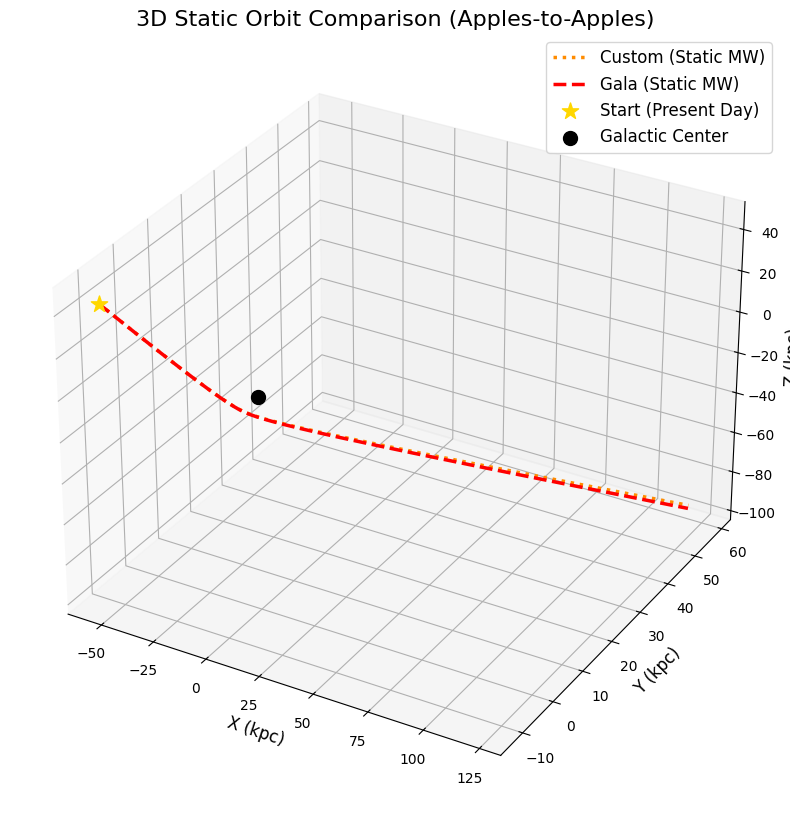

In [25]:
print("Starting custom integration with static MW-only potential (benchmark)...")

static_potential = MWPotential()

custom_static_orbit = np.zeros((N_STEPS, 6))
custom_static_orbit[0] = np.concatenate([initial_pos_custom, initial_vel_custom])

pos, vel = initial_pos_custom, initial_vel_custom

for i in tqdm(range(N_STEPS - 1), desc="Custom Static Integration"):
    pos, vel = leapfrog_step(pos, vel, DT, static_potential.get_acceleration_mw_only)
    custom_static_orbit[i+1] = np.concatenate([pos, vel])

print("Custom static integration complete.")

print("\nIntegrating orbit with Gala's static MilkyWayPotential for comparison...")

gala_potential = gp.MilkyWayPotential()
initial_phasespace_gala = gd.PhaseSpacePosition(pos=initial_pos_gala, vel=initial_vel_gala)
gala_orbit = gala_potential.integrate_orbit(
    initial_phasespace_gala, 
    dt=DT*u.Myr, 
    n_steps=N_STEPS, 
    Integrator=gi.LeapfrogIntegrator
)

print("Gala integration complete.")

fig_3d_static = plt.figure(figsize=(12, 10))
ax_3d_static = fig_3d_static.add_subplot(111, projection='3d')

ax_3d_static.plot(custom_static_orbit[:, 0], custom_static_orbit[:, 1], custom_static_orbit[:, 2],
           label='Custom (Static MW)', lw=2.5, color='darkorange', linestyle=':')
ax_3d_static.plot(gala_orbit.x, gala_orbit.y, gala_orbit.z,
           label='Gala (Static MW)', lw=2.5, color='red', linestyle='--')

ax_3d_static.scatter(initial_pos_custom[0], initial_pos_custom[1], initial_pos_custom[2],
              color='gold', s=150, marker='*', label='Start (Present Day)', zorder=5)
ax_3d_static.scatter(0, 0, 0, color='black', s=100, marker='o', label='Galactic Center')

ax_3d_static.set_xlabel("X (kpc)", fontsize=12)
ax_3d_static.set_ylabel("Y (kpc)", fontsize=12)
ax_3d_static.set_zlabel("Z (kpc)", fontsize=12)
ax_3d_static.set_title("3D Static Orbit Comparison (Apples-to-Apples)", fontsize=16)
ax_3d_static.legend(fontsize=12)
plt.show()

In [26]:
print("Starting custom integration with dynamic MW+LMC potential...")

dynamic_potential = MWPotential(mw_orbit_path=mw_orbit_path, lmc_orbit_path=lmc_orbit_path)

custom_orbit = np.zeros((N_STEPS, 6)) # [x, y, z, vx, vy, vz]
custom_orbit[0] = np.concatenate([initial_pos_custom, initial_vel_custom])
energies = np.zeros(N_STEPS)

pos, vel = initial_pos_custom, initial_vel_custom

# custom integration loop
for i in tqdm(range(N_STEPS), desc="Custom Integration"):
    t = times[i]
    energies[i] = dynamic_potential.get_total_energy(pos, vel, t)
    
    pos, vel = leapfrog_step_time_varying(pos, vel, t, DT, dynamic_potential)
    
    if i < N_STEPS - 1:
        custom_orbit[i+1] = np.concatenate([pos, vel])

print("Custom integration complete.")

/mnt/c/Users/Andrew Qin/Desktop/HVS/src/hvs_orbital_kinematics/interpolators.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/mnt/c/Users/Andrew Qin/Desktop/HVS/src/hvs_orbital_kinematics/interpolators.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Starting custom integration with dynamic MW+LMC potential...


Custom Integration: 100%|██████████| 800/800 [00:00<00:00, 1670.76it/s]

Custom integration complete.


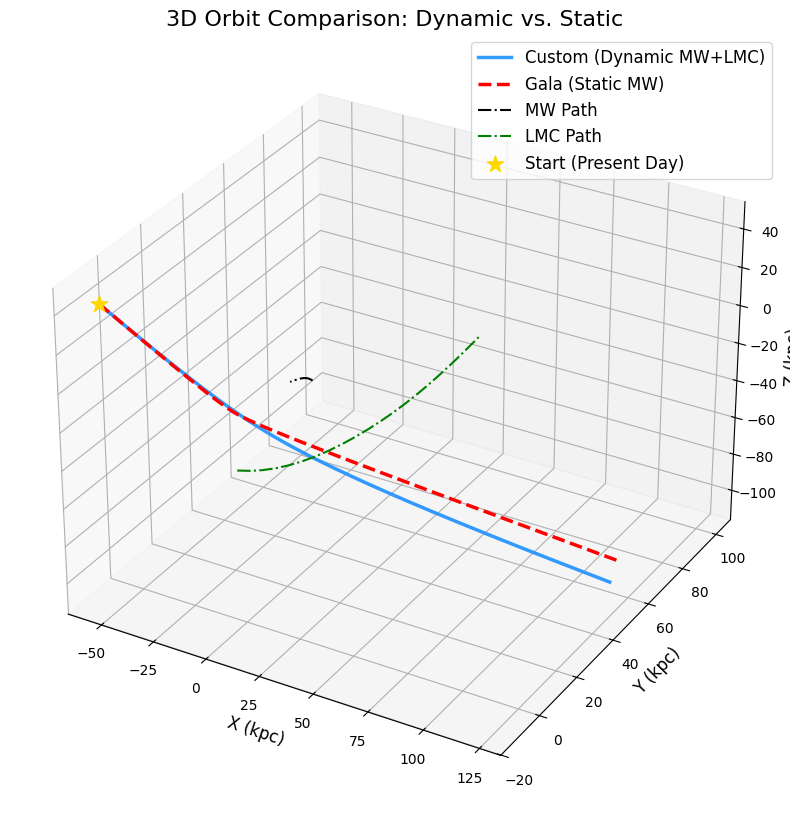

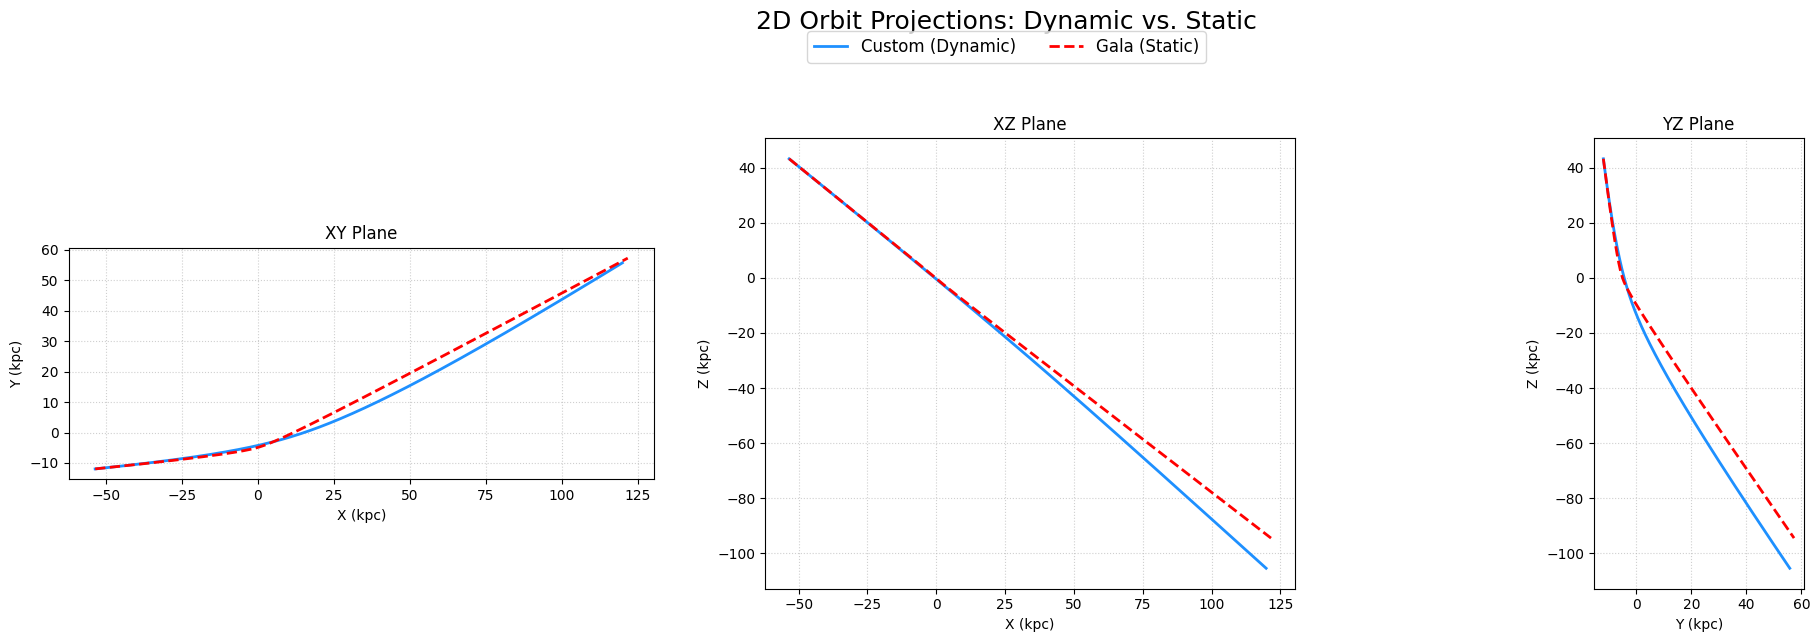

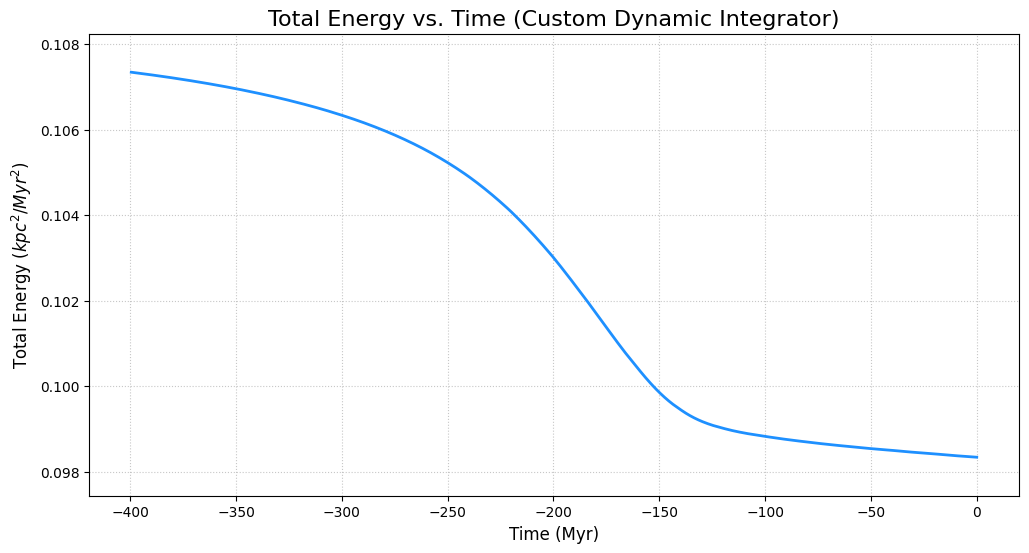

In [ ]:
mw_trajectory = np.array([dynamic_potential.mw_interpolator.get_position(t) for t in times])
lmc_trajectory = np.array([dynamic_potential.lmc_interpolator.get_position(t) for t in times])

# 3d plot
fig_3d = plt.figure(figsize=(12, 10))
ax_3d = fig_3d.add_subplot(111, projection='3d')

# plot custom and gala orbits
ax_3d.plot(custom_orbit[:, 0], custom_orbit[:, 1], custom_orbit[:, 2],
           label='Custom (Dynamic MW+LMC)', lw=2.5, color='dodgerblue', alpha=0.9)
ax_3d.plot(gala_orbit.x, gala_orbit.y, gala_orbit.z,
           label='Gala (Static MW)', lw=2.5, color='red', linestyle='--')

# plot lmc and mw trajectories
ax_3d.plot(mw_trajectory[:, 0], mw_trajectory[:, 1], mw_trajectory[:, 2], 
           label='MW Path', color='black', linestyle='-.')
ax_3d.plot(lmc_trajectory[:, 0], lmc_trajectory[:, 1], lmc_trajectory[:, 2], 
           label='LMC Path', color='green', linestyle='-.')

ax_3d.scatter(initial_pos_custom[0], initial_pos_custom[1], initial_pos_custom[2],
              color='gold', s=150, marker='*', label='Start (Present Day)', zorder=5)

ax_3d.set_xlabel("X (kpc)", fontsize=12)
ax_3d.set_ylabel("Y (kpc)", fontsize=12)
ax_3d.set_zlabel("Z (kpc)", fontsize=12)
ax_3d.set_title("3D Orbit Comparison: Dynamic vs. Static", fontsize=16)
ax_3d.legend(fontsize=12)
plt.show()



fig_2d, axes_2d = plt.subplots(1, 3, figsize=(20, 6.5))
fig_2d.suptitle('2D Orbit Projections: Dynamic vs. Static', fontsize=18)

labels_dict = {'dynamic': 'Custom (Dynamic)', 'gala': 'Gala (Static)'}

# xy
axes_2d[0].plot(custom_orbit[:, 0], custom_orbit[:, 1], lw=2, color='dodgerblue', label=labels_dict['dynamic'])
axes_2d[0].plot(gala_orbit.x.value, gala_orbit.y.value, lw=2, color='red', linestyle='--', label=labels_dict['gala'])
axes_2d[0].set(xlabel='X (kpc)', ylabel='Y (kpc)', title='XY Plane', aspect='equal')

# xz
axes_2d[1].plot(custom_orbit[:, 0], custom_orbit[:, 2], lw=2, color='dodgerblue')
axes_2d[1].plot(gala_orbit.x.value, gala_orbit.z.value, lw=2, color='red', linestyle='--')
axes_2d[1].set(xlabel='X (kpc)', ylabel='Z (kpc)', title='XZ Plane', aspect='equal')

# yz
axes_2d[2].plot(custom_orbit[:, 1], custom_orbit[:, 2], lw=2, color='dodgerblue')
axes_2d[2].plot(gala_orbit.y.value, gala_orbit.z.value, lw=2, color='red', linestyle='--')
axes_2d[2].set(xlabel='Y (kpc)', ylabel='Z (kpc)', title='YZ Plane', aspect='equal')

for ax in axes_2d:
    ax.grid(True, linestyle=':', alpha=0.6)

handles, labels = axes_2d[0].get_legend_handles_labels()
fig_2d.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


# energy conservation
plt.figure(figsize=(12, 6))
plt.plot(times, energies, lw=2, color='dodgerblue')
plt.title('Total Energy vs. Time (Custom Dynamic Integrator)', fontsize=16)
plt.xlabel('Time (Myr)', fontsize=12)
plt.ylabel(r'Total Energy ($kpc^2 / Myr^2$)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
energy_range = np.max(energies) - np.min(energies)
plt.ylim(np.min(energies) - 0.1 * energy_range, np.max(energies) + 0.1 * energy_range)

# Prevent scientific notation on the y-axis if the numbers are small
ax_energy = plt.gca()
ax_energy.get_yaxis().get_major_formatter().set_useOffset(False)

plt.show()


### Conclusion: custom scheme seems to work reasonably well. see orbit_integration.ipynb for full analysis pipeline.